In [133]:
import copy
import openmm as mm
from openmm import app, unit
from openmm.app import PDBFile

In [134]:
with open('system_with_ligand_only.xml', 'r') as f:
    system_1 = mm.XmlSerializer.deserialize(f.read())
pdb = PDBFile('ligand_in_solvent.pdb')
system_1.addForce(mm.MonteCarloBarostat(1*unit.atmosphere, 300*unit.kelvin))
system_1.getForces()

[<openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x783563605ef0> >,
 <openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x783560341020> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x783560341110> >,
 <openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x783560341050> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x783560340f90> >,
 <openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x783560340e10> >]

In [135]:
ligand = list(pdb.topology.residues())[0]
rest_atoms = [atom.index for atom in ligand.atoms()]
len(rest_atoms)

151

In [136]:
# Create REST system
rest_system = mm.System()
# Create dict of vanilla system forces (for easy retrieval of force objects later)
system_forces = {type(force).__name__ : force for force in system_1.getForces()}

# Add particles
for particle_idx in range(system_1.getNumParticles()):
    particle_mass = system_1.getParticleMass(particle_idx)
    rest_system.addParticle(particle_mass)

# Copy barostat
if "MonteCarloBarostat" in system_forces:
    barostat = copy.deepcopy(system_forces["MonteCarloBarostat"])
    rest_system.addForce(barostat)

# Copy box vectors
box_vectors = system_1.getDefaultPeriodicBoxVectors()
rest_system.setDefaultPeriodicBoxVectors(*box_vectors)

# Copy constraints
for constraint_idx in range(system_1.getNumConstraints()):
    atom1, atom2, length = system_1.getConstraintParameters(constraint_idx)
    rest_system.addConstraint(atom1, atom2, length)

In [137]:
# Define the custom expression
bond_expression = "rest_scale * (K / 2) * (r - length)^2;"
bond_expression += "rest_scale = is_rest * lambda_rest_bonds * lambda_rest_bonds " \
                   "+ is_inter * lambda_rest_bonds " \
                   "+ is_nonrest;"

# Create custom force
rest_bond_force = mm.CustomBondForce(bond_expression)
rest_system.addForce(rest_bond_force)

# Add global parameters
rest_bond_force.addGlobalParameter("lambda_rest_bonds", 1.0)

# Add per-bond parameters for rest scaling
rest_bond_force.addPerBondParameter("is_rest")
rest_bond_force.addPerBondParameter("is_inter")
rest_bond_force.addPerBondParameter("is_nonrest")

# Add per-bond parameters for defining bond energy
rest_bond_force.addPerBondParameter('length')  # equilibrium bond length
rest_bond_force.addPerBondParameter('K')  # force constant

4

In [138]:
def get_rest_identifier(atoms, rest_atoms):
    """
    For a given atom or set of atoms, get the rest_id which is a list of binary ints that defines which
    (mutually exclusive) set the atom(s) belong to.

    If there is a single atom, the sets are: is_rest, is_nonrest
    If there is a set of atoms, the sets are: is_rest, is_inter, is_nonrest

    Example: if there is a single atom that is in the nonrest set, the rest_id is [0, 1]

    Arguments
    ---------
    atoms : set or int
        a set of hybrid atom indices or single atom
    rest_atoms : set or list
        a list (or list-like) of atoms whose interactions will be scaled by REST
    Returns
    -------
    rest_id : list
        list of binaries indicating which set the atom(s) belong to
    """

    if isinstance(atoms, int):
        rest_id = [0, 1] # Set the default rest_id to non-REST
        if atoms in rest_atoms:
            rest_id = [1, 0]
        return rest_id

    elif isinstance(atoms, set):
        rest_id = [0, 0, 1] # Set the default rest_id to non-REST
        if atoms.intersection(rest_atoms) != set(): # At least one of the atoms is REST
            if atoms.issubset(rest_atoms): # All atoms are REST
                rest_id = [1, 0, 0]
            else: # At least one (but not all) of the atoms is are REST
                rest_id = [0, 1, 0]
        return rest_id

    else:
        raise Exception(f"atoms is of type {type(atoms)}, but only `int` and `set` are allowable")

In [139]:
# Get vanilla system bond force
bond_force = system_forces['HarmonicBondForce']

# Set periodicity
if bond_force.usesPeriodicBoundaryConditions():
    rest_bond_force.setUsesPeriodicBoundaryConditions(True)

# Add bonds to rest_system
for term_idx in range(bond_force.getNumBonds()):
    # Get the bond parameters and rest id
    p1, p2, r0, k = bond_force.getBondParameters(term_idx)
    idx_set = set([p1, p2])
    rest_id = get_rest_identifier(idx_set, rest_atoms)

    # Add the bond
    bond_term = (p1, p2, rest_id + [r0, k])
    rest_bond_force.addBond(*bond_term)

In [140]:
# Define the custom expression
angle_expression = "rest_scale * (K / 2) * (theta - theta0)^2;"
angle_expression += "rest_scale = is_rest * lambda_rest_angles * lambda_rest_angles " \
                    "+ is_inter * lambda_rest_angles " \
                    "+ is_nonrest;"

# Create custom force
rest_angle_force = mm.CustomAngleForce(angle_expression)
rest_system.addForce(rest_angle_force)

# Add global parameters
rest_angle_force.addGlobalParameter("lambda_rest_angles", 1.0)

# Add per-angle parameters for rest scaling
rest_angle_force.addPerAngleParameter("is_rest")
rest_angle_force.addPerAngleParameter("is_inter")
rest_angle_force.addPerAngleParameter("is_nonrest")

# Add per-angle parameters for defining angle energy
rest_angle_force.addPerAngleParameter('theta0')  # equilibrium angle
rest_angle_force.addPerAngleParameter('K')  # force constant

# Get vanilla system angle force
angle_force = system_forces['HarmonicAngleForce']

# Set periodicity
if angle_force.usesPeriodicBoundaryConditions():
    rest_angle_force.setUsesPeriodicBoundaryConditions(True)

# Add angles to rest_system
for term_idx in range(angle_force.getNumAngles()):
    # Get the angle parameters and rest id
    p1, p2, p3, theta0, k = angle_force.getAngleParameters(term_idx)
    idx_set = set([p1, p2, p3])
    rest_id = get_rest_identifier(idx_set, rest_atoms)

    # Add the angle
    angle_term = (p1, p2, p3, rest_id + [theta0, k])
    rest_angle_force.addAngle(*angle_term)

In [141]:
# Define the custom expression
torsion_expression = "rest_scale * U;"
torsion_expression += "rest_scale = is_rest * lambda_rest_torsions * lambda_rest_torsions " \
                      "+ is_inter * lambda_rest_torsions " \
                      "+ is_nonrest;"
torsion_expression += "U = (K * (1 + cos(periodicity * theta - phase)));"

# Create custom force
rest_torsion_force = mm.CustomTorsionForce(torsion_expression)
rest_system.addForce(rest_torsion_force)

# Add global parameters
rest_torsion_force.addGlobalParameter("lambda_rest_torsions", 1.0)

# Add per-torsion parameters for rest scaling
rest_torsion_force.addPerTorsionParameter("is_rest")
rest_torsion_force.addPerTorsionParameter("is_inter")
rest_torsion_force.addPerTorsionParameter("is_nonrest")

# Add per-torsion parameters for defining torsion energy
rest_torsion_force.addPerTorsionParameter('periodicity')
rest_torsion_force.addPerTorsionParameter('phase') # phase offset
rest_torsion_force.addPerTorsionParameter('K') # force constant

# Get vanilla system torsion force
torsion_force = system_forces['PeriodicTorsionForce']

# Set periodicity
if torsion_force.usesPeriodicBoundaryConditions():
    rest_torsion_force.setUsesPeriodicBoundaryConditions(True)

# Add torsions to rest_system
for torsion_idx in range(torsion_force.getNumTorsions()):
    # Get the torsion parameters and rest id
    p1, p2, p3, p4, periodicity, phase, K = torsion_force.getTorsionParameters(torsion_idx)
    idx_set = set([p1, p2, p3, p4])
    rest_id = get_rest_identifier(idx_set, rest_atoms)

    # Add torsion
    torsion_term = (p1, p2, p3, p4, rest_id + [periodicity, phase, K])
    rest_torsion_force.addTorsion(*torsion_term)

In [142]:
# Create nonbonded force
rest_nonbonded_force = mm.NonbondedForce()
rest_system.addForce(rest_nonbonded_force)

# Get vanilla system nonbonded force
nonbonded_force = system_forces['NonbondedForce']

# Set the nonbonded method and related parameters
nonbonded_method = nonbonded_force.getNonbondedMethod()
rest_nonbonded_force.setNonbondedMethod(nonbonded_method)
if nonbonded_method != mm.NonbondedForce.NoCutoff:
    epsilon_solvent = nonbonded_force.getReactionFieldDielectric()
    cutoff = nonbonded_force.getCutoffDistance()
    rest_nonbonded_force.setReactionFieldDielectric(epsilon_solvent)
    rest_nonbonded_force.setCutoffDistance(cutoff)
if nonbonded_method in [mm.NonbondedForce.PME, mm.NonbondedForce.Ewald]:
    [alpha_ewald, nx, ny, nz] = nonbonded_force.getPMEParameters()
    delta = nonbonded_force.getEwaldErrorTolerance()
    rest_nonbonded_force.setPMEParameters(alpha_ewald, nx, ny, nz)
    rest_nonbonded_force.setEwaldErrorTolerance(delta)

# Copy switching function from vanilla system
switch_bool = nonbonded_force.getUseSwitchingFunction()
rest_nonbonded_force.setUseSwitchingFunction(switch_bool)
if switch_bool:
    switching_distance = nonbonded_force.getSwitchingDistance()
    rest_nonbonded_force.setSwitchingDistance(switching_distance)

# Copy dispersion correction
dispersion_bool = nonbonded_force.getUseDispersionCorrection()
rest_nonbonded_force.setUseDispersionCorrection(dispersion_bool)

# Add global parameters
rest_nonbonded_force.addGlobalParameter('lambda_rest_electrostatics', 0.)
rest_nonbonded_force.addGlobalParameter('lambda_rest_sterics', 0.)

1

In [143]:
# Add nonbondeds to rest_system
for particle_idx in range(nonbonded_force.getNumParticles()):
    # Get the nonbonded parameters and rest id
    q, sigma, epsilon = nonbonded_force.getParticleParameters(particle_idx)
    rest_id = get_rest_identifier(particle_idx, rest_atoms)

    # Add particles and offsets
    if rest_id == [0, 1]: # nonrest
        rest_nonbonded_force.addParticle(q, sigma, epsilon)

    else: # rest
        rest_nonbonded_force.addParticle(q, sigma, epsilon)
        rest_nonbonded_force.addParticleParameterOffset('lambda_rest_electrostatics', particle_idx, q, 0.0*sigma, epsilon*0.0)
        rest_nonbonded_force.addParticleParameterOffset('lambda_rest_sterics', particle_idx, q*0.0, 0.0*sigma, epsilon)

# Handle exceptions
for exception_idx in range(nonbonded_force.getNumExceptions()):
    # Get exception parameters and rest id
    p1, p2, chargeProd, sigma, epsilon = nonbonded_force.getExceptionParameters(exception_idx)
    idx_set = set([p1, p2])
    rest_id = get_rest_identifier(idx_set, rest_atoms)

    # Add exceptions and offsets
    exc_idx = rest_nonbonded_force.addException(p1, p2, chargeProd, sigma, epsilon)
    if rest_id == [0, 0, 1]: # nonrest
        pass

    elif rest_id == [1, 0, 0]: # rest
        rest_nonbonded_force.addExceptionParameterOffset('lambda_rest_sterics', exc_idx, chargeProd, 0.0*sigma, epsilon)

    elif rest_id == [0, 1, 0]: # inter
        rest_nonbonded_force.addExceptionParameterOffset('lambda_rest_electrostatics', exc_idx, chargeProd, 0.0*sigma, epsilon)


In [144]:
import math
import logging
import numpy as np
from openmmtools.constants import kB
from openmmtools import cache, mcmc, multistate
from openmmtools.multistate import ReplicaExchangeSampler
from openmmtools.states import GlobalParameterState, SamplerState, ThermodynamicState, CompoundThermodynamicState

In [145]:
class RESTState(GlobalParameterState):
    lambda_rest_bonds = GlobalParameterState.GlobalParameter('lambda_rest_bonds', standard_value=1.0)
    lambda_rest_angles = GlobalParameterState.GlobalParameter('lambda_rest_angles', standard_value=1.0)
    lambda_rest_torsions = GlobalParameterState.GlobalParameter('lambda_rest_torsions', standard_value=1.0)
    lambda_rest_electrostatics = GlobalParameterState.GlobalParameter('lambda_rest_electrostatics', standard_value=0.0)
    lambda_rest_sterics = GlobalParameterState.GlobalParameter('lambda_rest_sterics', standard_value=0.0)

    def set_rest_parameters(self, beta_m, beta_0):
        """Set all defined lambda parameters to the given value.

        The undefined parameters (i.e. those being set to None) remain undefined.

        Parameters
        ----------
        new_value : float
            The new value for all defined parameters.
        """
        lambda_functions = {'lambda_rest_bonds': lambda beta_m, beta_0 : np.sqrt(beta_m / beta_0),
                 'lambda_rest_angles' : lambda beta_m, beta_0 : np.sqrt(beta_m / beta_0),
                 'lambda_rest_torsions' : lambda beta_m, beta_0 : np.sqrt(beta_m / beta_0),
                 'lambda_rest_electrostatics' : lambda beta_m, beta_0 : np.sqrt(beta_m / beta_0) - 1,
                 'lambda_rest_sterics' : lambda beta_m, beta_0 : beta_m / beta_0 - 1
                 }

        for parameter_name in self._parameters:
            if self._parameters[parameter_name] is not None:
                new_value = lambda_functions[parameter_name](beta_m, beta_0)
                setattr(self, parameter_name, new_value)

Need set temperatures for replicas

In [146]:
# Set temperatures for each thermodynamic state
n_replicas = 12  # Number of temperature replicas
T_min = 300 * unit.kelvin  # Minimum temperature (i.e., temperature of desired distribution)
T_max = 600 * unit.kelvin  # Maximum temperature
temperatures = [T_min + (T_max - T_min) * (math.exp(float(i) / float(n_replicas-1)) - 1.0) / (math.e - 1.0)
                for i in range(n_replicas)]
temperatures

[Quantity(value=300.0, unit=kelvin),
 Quantity(value=316.61591916385663, unit=kelvin),
 Quantity(value=334.8131660475402, unit=kelvin),
 Quantity(value=354.74223472440497, unit=kelvin),
 Quantity(value=376.5679417044706, unit=kelvin),
 Quantity(value=400.4707889926977, unit=kelvin),
 Quantity(value=426.6484568687549, unit=kelvin),
 Quantity(value=455.31743873380157, unit=kelvin),
 Quantity(value=486.7148315447216, unit=kelvin),
 Quantity(value=521.1002966429818, unit=kelvin),
 Quantity(value=558.758207194473, unit=kelvin),
 Quantity(value=600.0, unit=kelvin)]

In [147]:
# Create reference thermodynamic state
rest_state = RESTState.from_system(rest_system)
thermostate = ThermodynamicState(rest_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate, composable_states=[rest_state])

In [148]:
# Create thermodynamic states
sampler_state =  SamplerState(pdb.positions, box_vectors=rest_system.getDefaultPeriodicBoxVectors())
beta_0 = 1/(kB*T_min)
thermodynamic_state_list = []
sampler_state_list = []
for temperature in temperatures:
    # Create a thermodynamic state with REST interactions scaled to the given temperature
    beta_m = 1/(kB*temperature)
    compound_thermodynamic_state_copy = copy.deepcopy(compound_thermodynamic_state)
    compound_thermodynamic_state_copy.set_rest_parameters(beta_m, beta_0)
    thermodynamic_state_list.append(compound_thermodynamic_state_copy)

    # Generate a sampler_state with minimized positions
    context, integrator = cache.global_context_cache.get_context(compound_thermodynamic_state_copy)
    sampler_state.apply_to_context(context, ignore_velocities=True)
    mm.LocalEnergyMinimizer.minimize(context)
    sampler_state.update_from_context(context)
    sampler_state_list.append(copy.deepcopy(sampler_state))

setting mcmc move interval and iteration numbers

In [149]:
# Set up sampler
_logger = logging.getLogger()
_logger.setLevel(logging.DEBUG)
move = mcmc.LangevinDynamicsMove(timestep=2*unit.femtoseconds, n_steps=500)
simulation = ReplicaExchangeSampler(mcmc_moves=move, number_of_iterations=5000)

# Run repex
reporter_file = "test_run.nc"
reporter = multistate.MultiStateReporter(reporter_file)
simulation.create(thermodynamic_states=thermodynamic_state_list,
                  sampler_states=sampler_state_list,
                  storage=reporter)
simulation.run()

Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
        Chodera JD and Shirts MR. Replica exchange and expanded ensemble simulations as Gibbs multistate: Simple improvements for enhanced mixing. J. Chem. Phys., 135:194110, 2011. DOI:10.1063/

DEBUG:2025-09-14 15:39:52,616:jax._src.dispatch:198: Finished tracing + transforming _reduce_min for pjit in 0.000722408 sec
DEBUG:2025-09-14 15:39:52,618:jax._src.dispatch:198: Finished tracing + transforming subtract for pjit in 0.000356913 sec
DEBUG:2025-09-14 15:39:52,619:jax._src.dispatch:198: Finished tracing + transforming subtract for pjit in 0.000190496 sec
DEBUG:2025-09-14 15:39:52,620:jax._src.dispatch:198: Finished tracing + transforming _broadcast_arrays for pjit in 0.000199080 sec
DEBUG:2025-09-14 15:39:52,621:jax._src.dispatch:198: Finished tracing + transforming _where for pjit in 0.001331329 sec
DEBUG:2025-09-14 15:39:52,622:jax._src.dispatch:198: Finished tracing + transforming real for pjit in 0.000070333 sec
DEBUG:2025-09-14 15:39:52,622:jax._src.dispatch:198: Finished tracing + transforming _reduce_max for pjit in 0.000337124 sec
DEBUG:2025-09-14 15:39:52,623:jax._src.dispatch:198: Finished tracing + transforming isfinite for pjit in 0.000105143 sec
DEBUG:2025-09-1

In [3]:
def plot_dihedral_angles(traj_cont, atom_indices):
    dihedral_angles = md.compute_dihedrals(traj_cont, [atom_indices])
    dihedral_angles_deg = np.degrees(dihedral_angles[:, 0])
    #plt.figure(figsize=(8, 6))
    #plt.plot(np.arange(len(dihedral_angles_deg)), dihedral_angles_deg)
    #plt.xlabel('Frame')
    #plt.ylabel('Dihedral Angle (degrees)')
    #plt.title('Dihedral Angle Over Time')
    #plt.ylim(-180, 180)
    #plt.grid(True)
    #plt.show()
    #plt.close()
    plt.figure(figsize=(8, 6))
    sns.kdeplot(dihedral_angles_deg)
    plt.xlabel('Dihedral Angle (degrees)')
    plt.ylabel('Density')
    plt.title('Dihedral Angle Distribution')
    plt.xlim(-180, 180)
    plt.grid(True)
    plt.show()
    plt.close()
    return np.mean(dihedral_angles_deg)

In [19]:
def plot_distance(traj_cont, atom_indices):
    atom_pairs = np.array([atom_indices])
    distances = md.compute_distances(traj_cont, atom_pairs)
    distance = distances[:, 0]
    #plt.figure(figsize=(8, 6))
    #plt.plot(np.arange(len(distance)), distance
    #plt.xlabel('Frame')
    #plt.ylabel('Distance (nm)')
    #plt.title('Distance Over Time')
    #plt.ylim(0.3, 0.4)
    #plt.grid(True)
    #plt.show()
    #plt.close()
    plt.figure(figsize=(8, 6))
    sns.kdeplot(distance)
    plt.xlabel('Distance (nm)')
    plt.ylabel('Density')
    plt.title('Distance Distribution')
    plt.xlim(0.3, 0.4)
    plt.grid(True)
    plt.show()
    plt.close()
    return np.mean(distance)

Iteration 0 with 12 states
Iteration 50 with 12 states
Iteration 100 with 12 states
Iteration 150 with 12 states
Iteration 200 with 12 states
Iteration 250 with 12 states
Iteration 300 with 12 states
Iteration 350 with 12 states
Iteration 400 with 12 states
Iteration 450 with 12 states
Iteration 500 with 12 states
Iteration 550 with 12 states
Iteration 600 with 12 states
Iteration 650 with 12 states
Iteration 700 with 12 states
Iteration 750 with 12 states
Iteration 800 with 12 states
Iteration 850 with 12 states
Iteration 900 with 12 states
Iteration 950 with 12 states
Iteration 1000 with 12 states
Iteration 1050 with 12 states
Iteration 1100 with 12 states
Iteration 1150 with 12 states
Iteration 1200 with 12 states
Iteration 1250 with 12 states
Iteration 1300 with 12 states
Iteration 1350 with 12 states
Iteration 1400 with 12 states
Iteration 1450 with 12 states
Iteration 1500 with 12 states
Iteration 1550 with 12 states
Iteration 1600 with 12 states
Iteration 1650 with 12 states
Ite

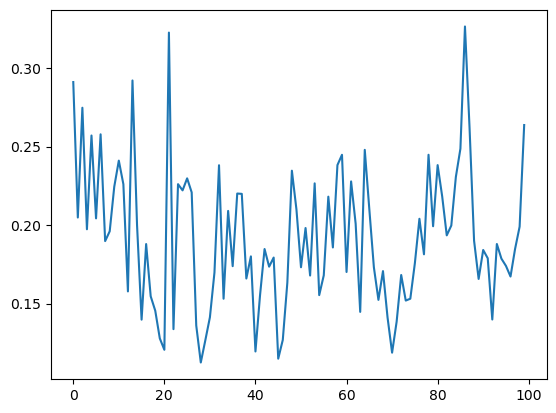

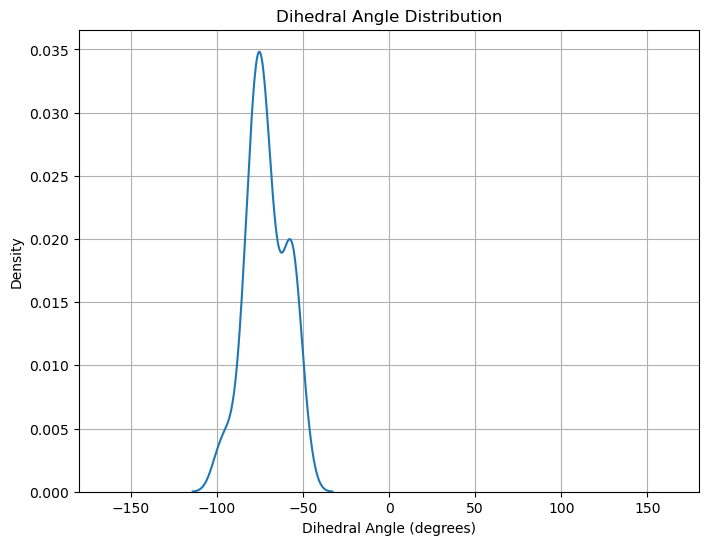

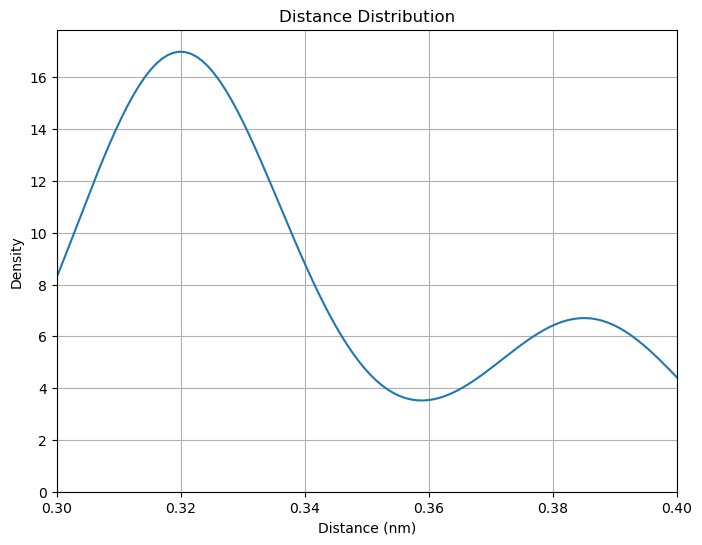

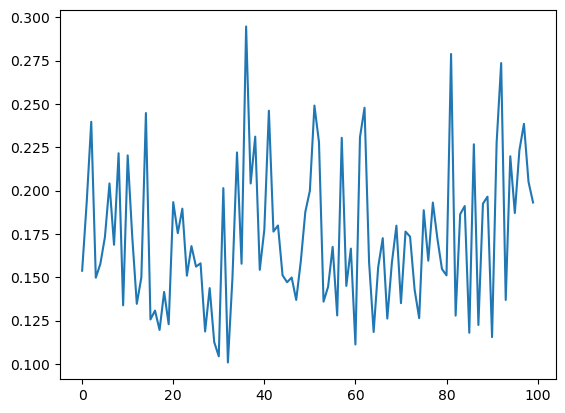

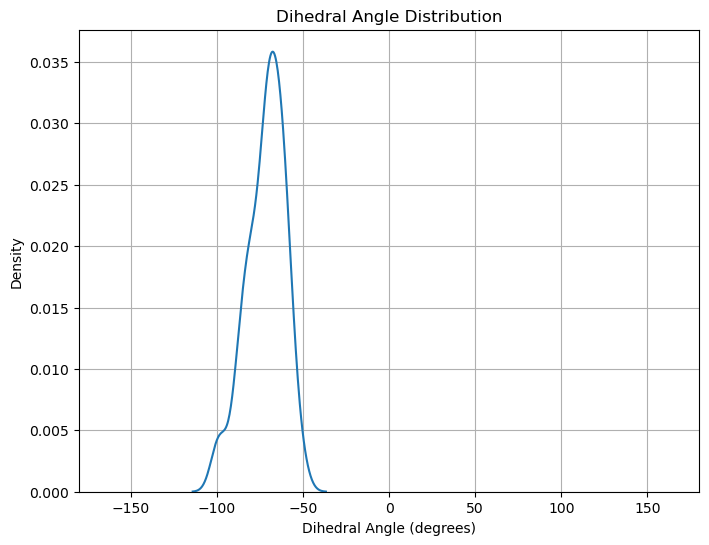

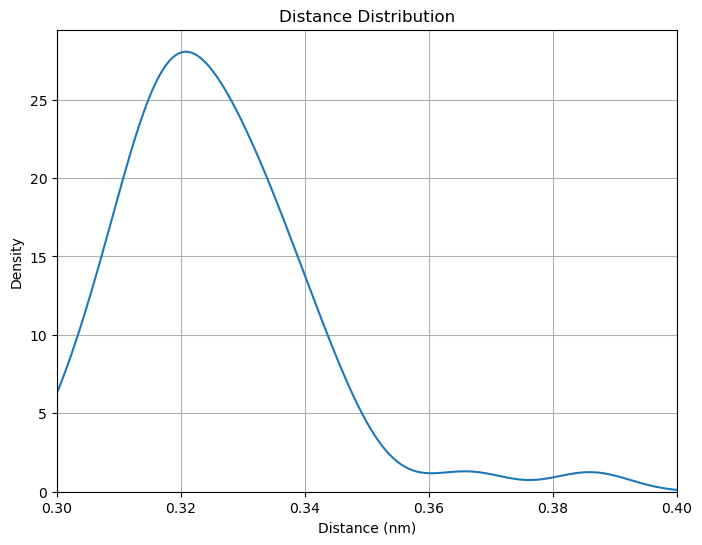

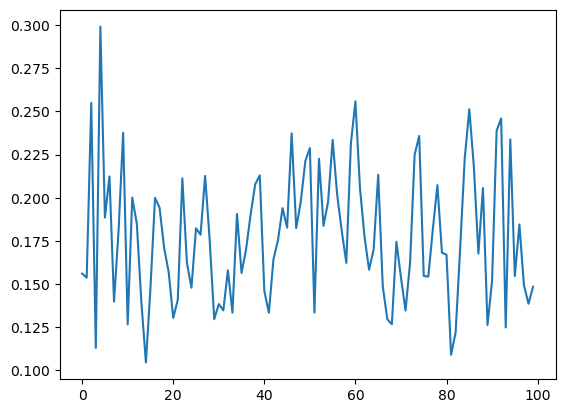

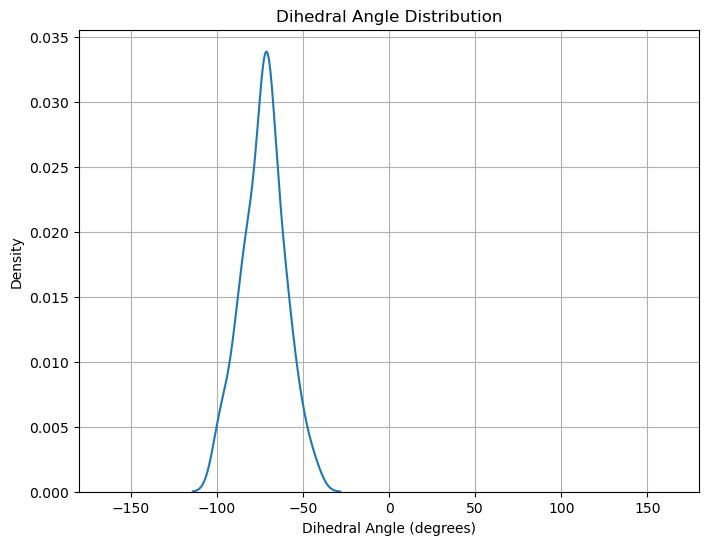

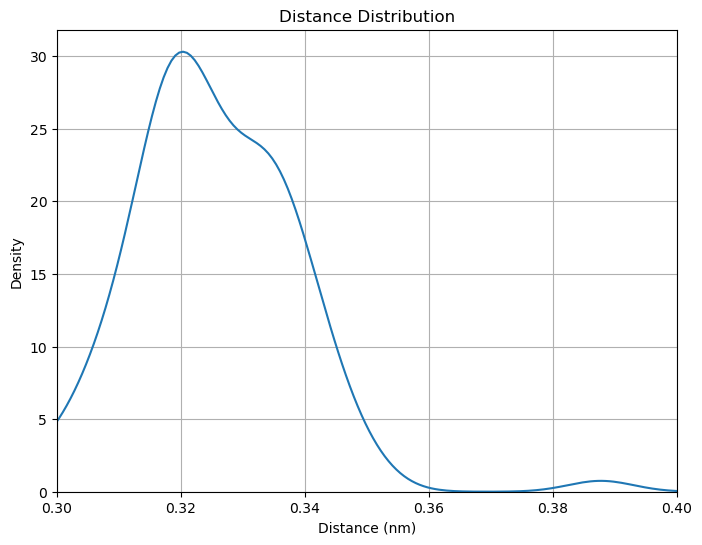

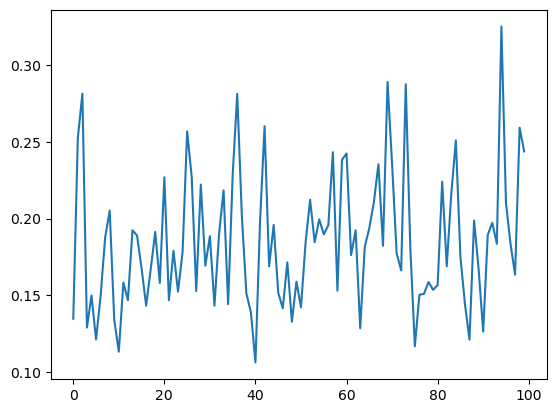

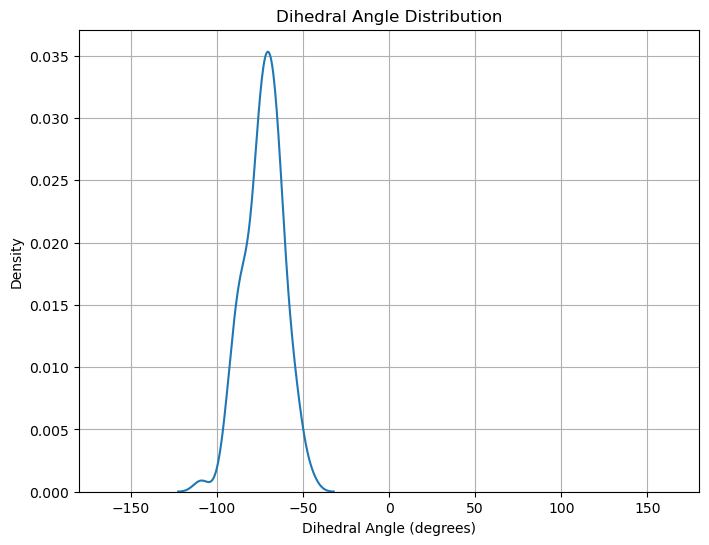

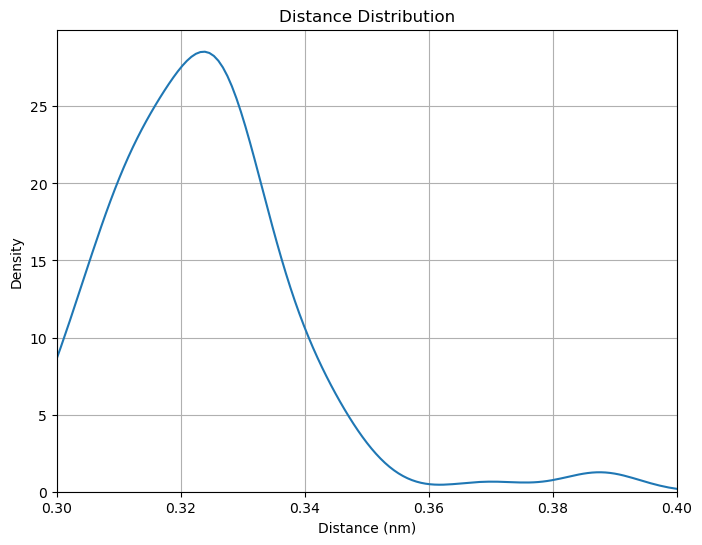

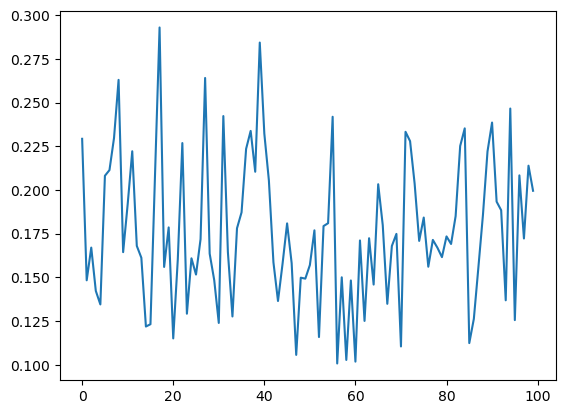

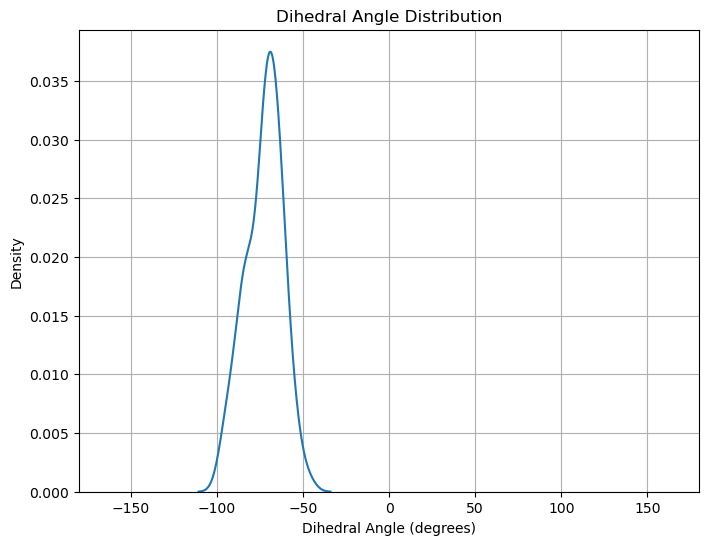

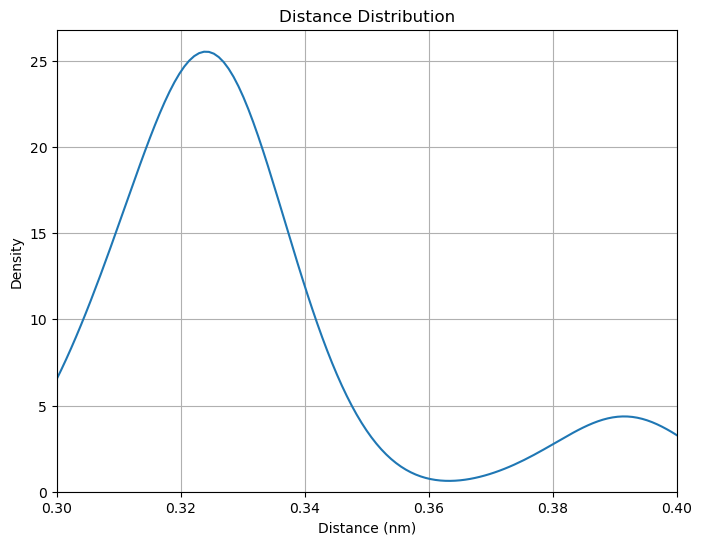

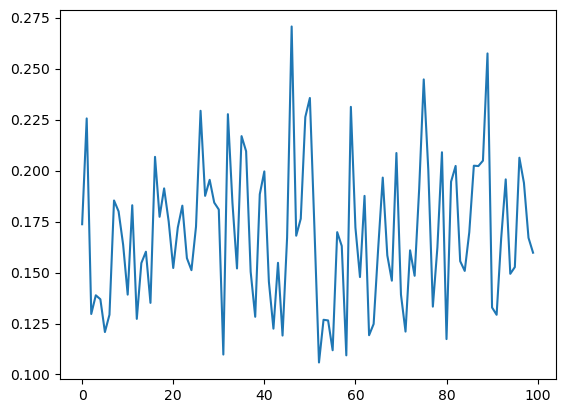

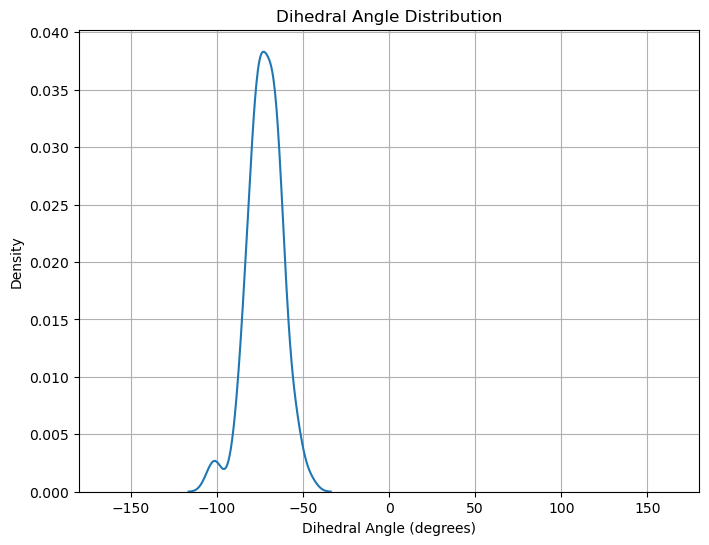

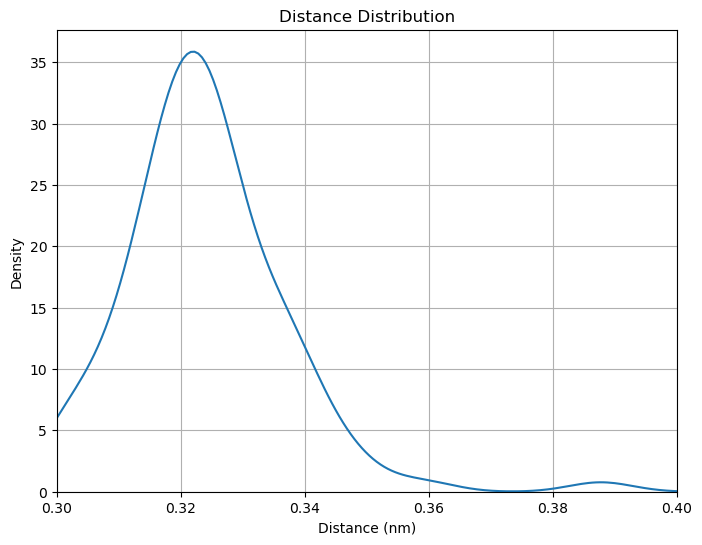

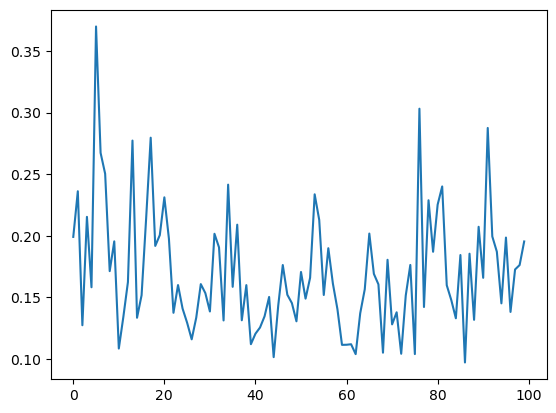

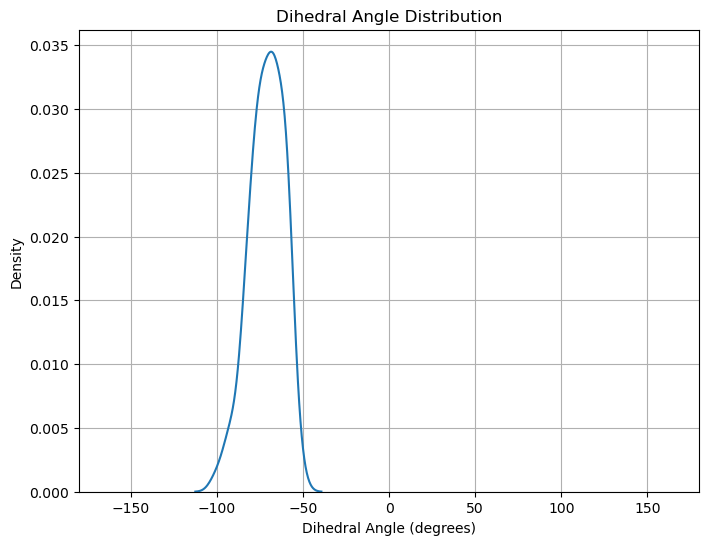

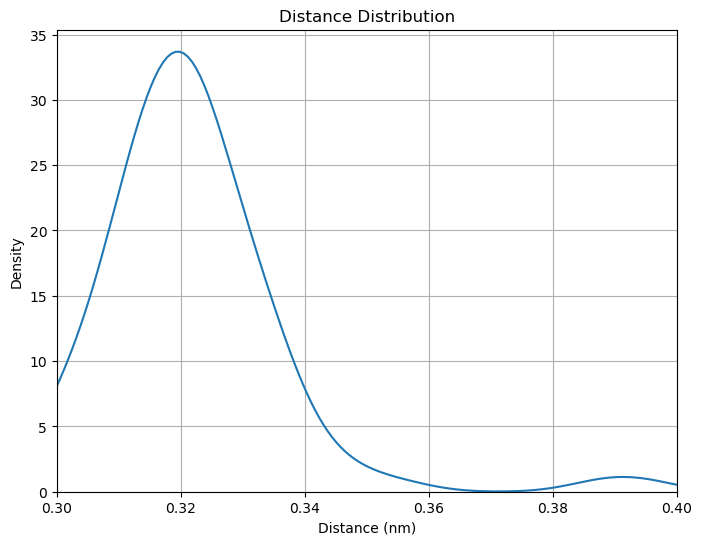

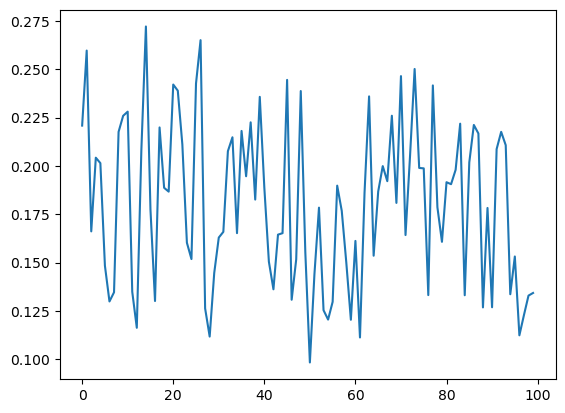

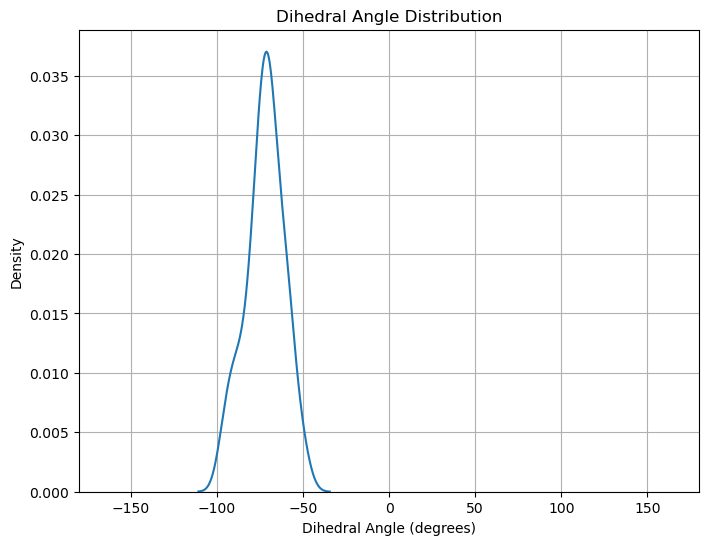

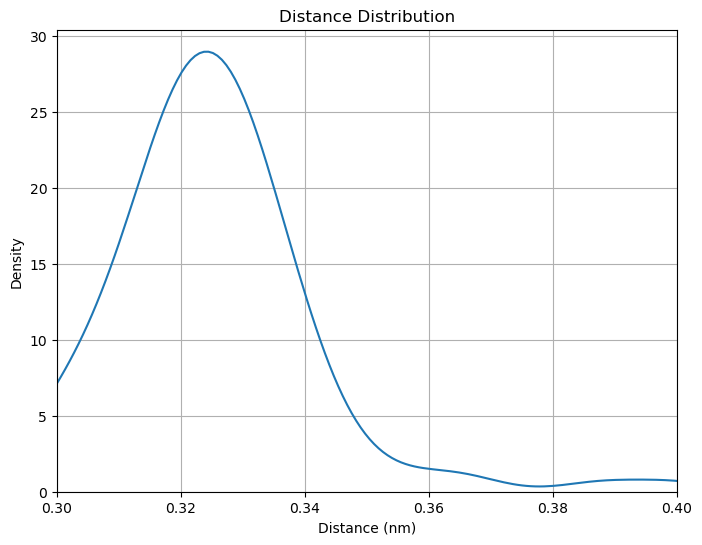

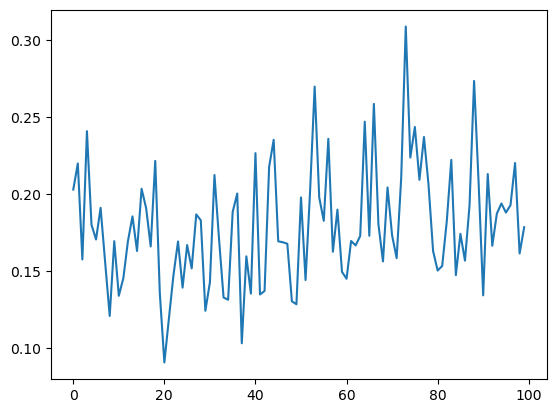

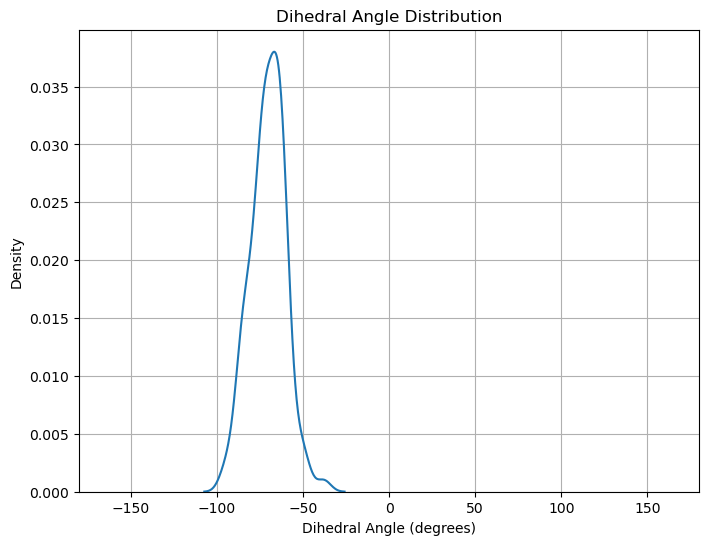

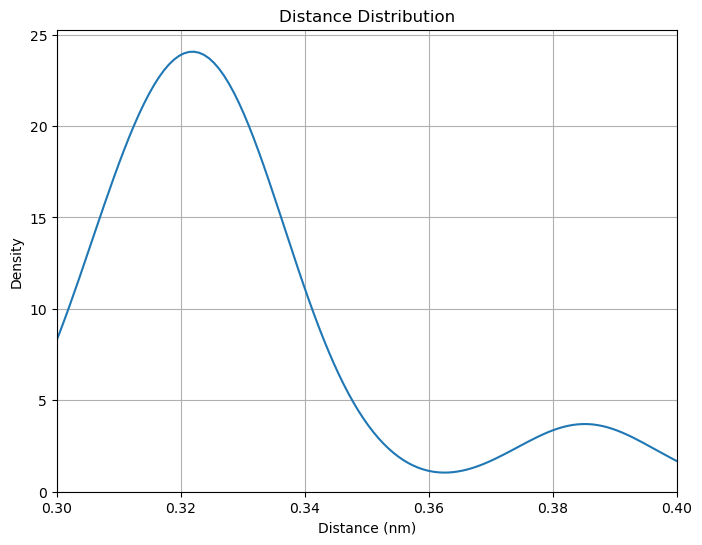

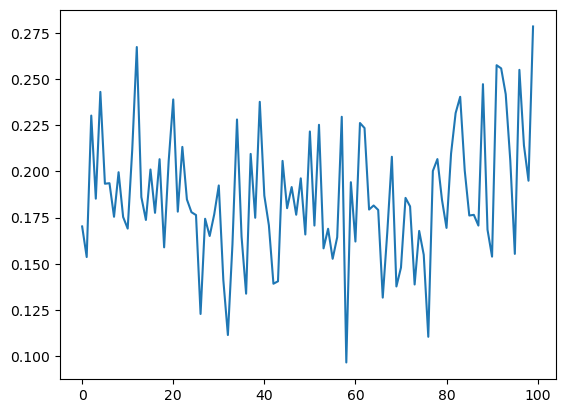

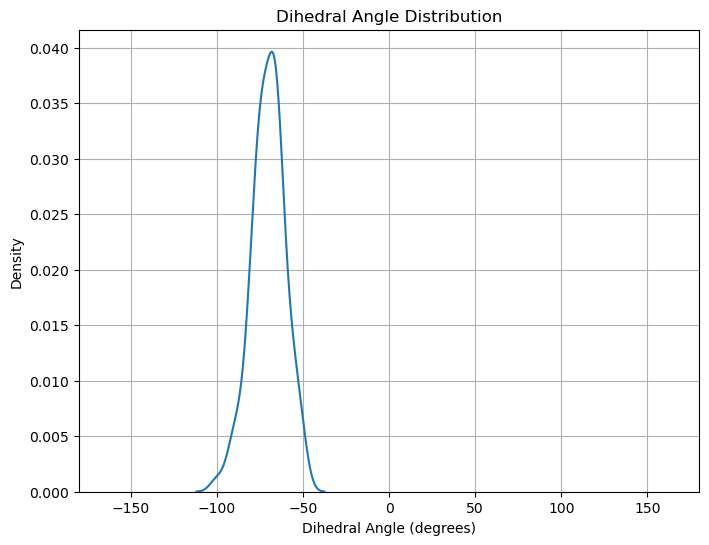

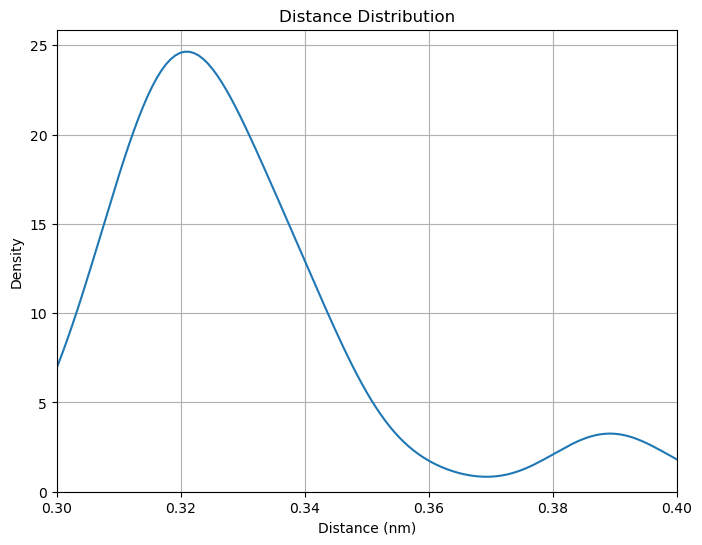

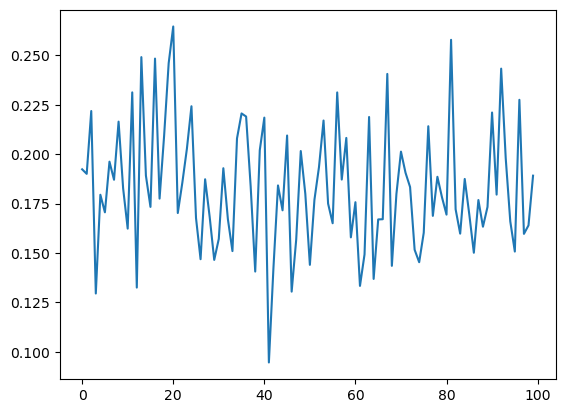

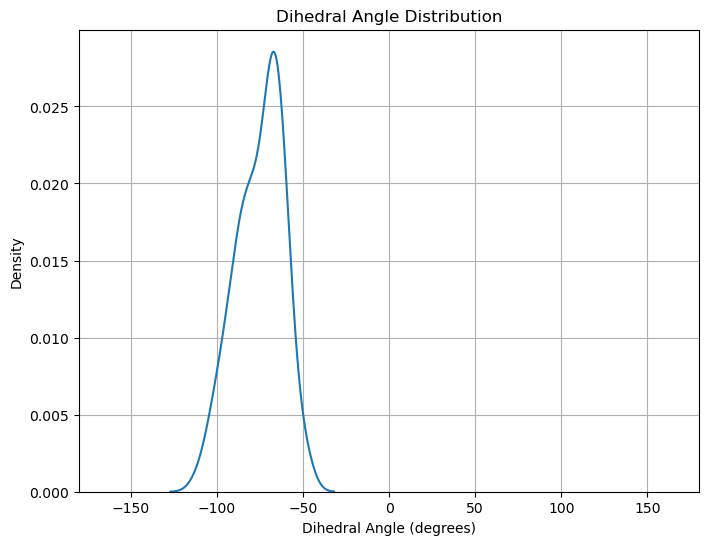

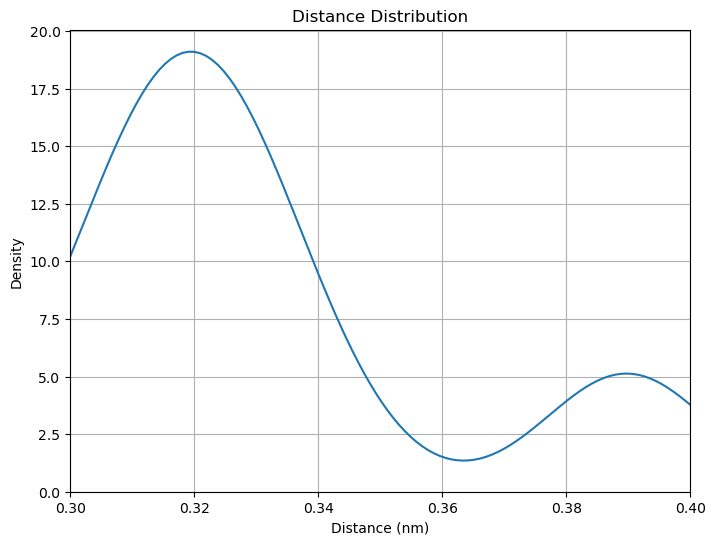

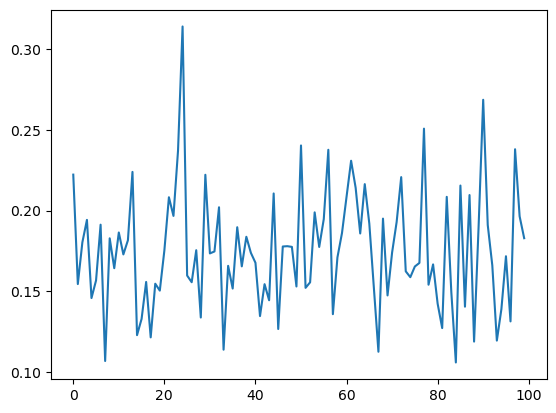

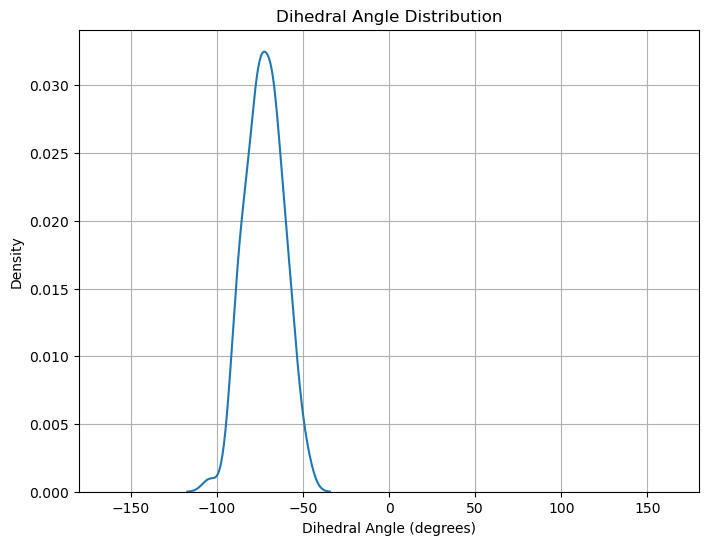

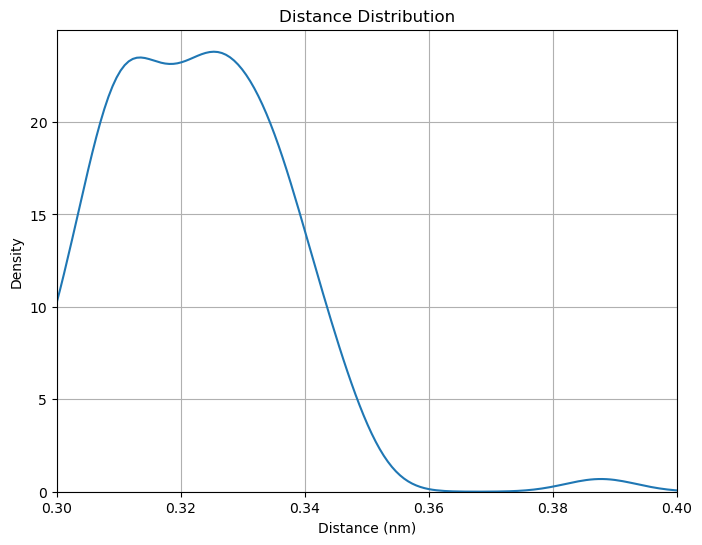

In [22]:
from openmmtools.multistate import MultiStateReporter
import mdtraj as md
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

reporter_path = 'test_run.nc'
storage_path = 'test_run_checkpoint.nc'
pdb_path = 'ligand_in_solvent.pdb'

reporter = MultiStateReporter(reporter_path, open_mode='r')
pdb = md.load(pdb_path)
topology = pdb.topology

last_iteration = reporter.read_last_iteration()    
positions = []
pos_dict = {}

for i in range(last_iteration + 1):
    sampler_states = reporter.read_sampler_states(iteration=i)
    try:
        state_count = len(sampler_states)
        if state_count:
            print(f"Iteration {i} with {state_count} states")
        
        
        for ii in range(state_count):
            pos = sampler_states[ii].positions

            if ii not in pos_dict:
                pos_dict[ii] = []
            pos_dict[ii].append(pos)

            #for iii in dir(sampler_states[ii]):
                #print(iii, getattr(sampler_states[ii], iii))
            
            #if not any(np.array_equal(pos, p) for p in positions):
            positions.append(pos)
    except:
        continue

reporter.close()

traj = md.Trajectory(np.array(positions), topology)
ligand_indices = np.arange(0, 151)
traj.superpose(traj, 0, atom_indices=ligand_indices)
traj_ligand = traj.atom_slice(ligand_indices)

# Remove duplicate geometries
#precision = 1
#rounded_xyz = np.round(traj_ligand.xyz, precision)
#_, unique_indices = np.unique(rounded_xyz.reshape(rounded_xyz.shape[0], -1), axis=0, return_index=True)
#traj_ligand_unique = traj_ligand[unique_indices]
#export to dcd
traj_ligand.save_pdb("rest_ligand_samples.pdb")

for k, v in pos_dict.items():
    traj_k = md.Trajectory(np.array(v), topology)
    ligand_indices = np.arange(0, 151)
    traj_k.superpose(traj_k, 0, atom_indices=ligand_indices)
    traj_k_ligand = traj_k.atom_slice(ligand_indices)

    #rmsd = md.rmsd(traj_k_ligand, traj_k_ligand, 0)
    #To calculate the RMSD between each frame and the previous frame
    rmsd_fluctuations = []
    for i in range(1, traj_k_ligand.n_frames):
        current_frame = traj_k_ligand[i]
        previous_frame = traj_k_ligand[i-1]
        rmsd_val = md.rmsd(current_frame, previous_frame)
        rmsd_fluctuations.append(rmsd_val[0])
    rmsd_fluctuations = np.array(rmsd_fluctuations)
    plt.plot(range(len(rmsd_fluctuations)), rmsd_fluctuations)
    
    plot_dihedral_angles(traj_k_ligand, [11, 10, 9, 4])
    plot_distance(traj_k_ligand, [55, 58])

    # Remove duplicate geometries
    #precision = 1
    #rounded_xyz = np.round(traj_ligand.xyz, precision)
    #_, unique_indices = np.unique(rounded_xyz.reshape(rounded_xyz.shape[0], -1), axis=0, return_index=True)
    #traj_ligand_unique = traj_ligand[unique_indices]
    #export to dcd

    traj_k_ligand.save_pdb(f"replica_{k}_ligand_samples.pdb")

In [289]:
velocity_data_list = []
reporter = MultiStateReporter(reporter_path, open_mode='r')
pdb = md.load(pdb_path)
topology = pdb.topology
for i in range(0, 5000):
    states = reporter.read_sampler_states(iteration=i)
    if states:
        for re, ii in enumerate(states):
            print('replica', re)
            velocity_data_list.append(ii.velocities)
            #for iii in dir(ii):
                #print(iii, getattr(ii, iii))

replica 0
replica 1
replica 2
replica 3
replica 4
replica 5
replica 6
replica 7
replica 8
replica 9
replica 10
replica 11
replica 0
replica 1
replica 2
replica 3
replica 4
replica 5
replica 6
replica 7
replica 8
replica 9
replica 10
replica 11
replica 0
replica 1
replica 2
replica 3
replica 4
replica 5
replica 6
replica 7
replica 8
replica 9
replica 10
replica 11
replica 0
replica 1
replica 2
replica 3
replica 4
replica 5
replica 6
replica 7
replica 8
replica 9
replica 10
replica 11
replica 0
replica 1
replica 2
replica 3
replica 4
replica 5
replica 6
replica 7
replica 8
replica 9
replica 10
replica 11
replica 0
replica 1
replica 2
replica 3
replica 4
replica 5
replica 6
replica 7
replica 8
replica 9
replica 10
replica 11
replica 0
replica 1
replica 2
replica 3
replica 4
replica 5
replica 6
replica 7
replica 8
replica 9
replica 10
replica 11
replica 0
replica 1
replica 2
replica 3
replica 4
replica 5
replica 6
replica 7
replica 8
replica 9
replica 10
replica 11
replica 0
replica 1
repl

In [348]:
import pandas as pd
import numpy as np
from pint import UnitRegistry
import mdtraj as md
from openmm import unit
from openmm.unit import Quantity

BOLTZ = 1.380649e-23 # J/K
AMU_TO_KG = 1.66053906660e-27      # kg/amu
NM_TO_M = 1.0e-9                  # m/nm
PS_TO_S = 1.0e-12                 # s/ps

masses = np.array([atom.element.mass for atom in traj_ligand.topology.atoms])
masses_in_si = masses * AMU_TO_KG  # Convert to kg

temperatures = []

# Loop through each frame's velocity data
for frame_velocities_data in velocity_data_list:
    velocities = unit.Quantity(frame_velocities_data[:151], unit.nanometer/unit.picosecond)
    velocities_in_si = velocities * (NM_TO_M / PS_TO_S)  # Convert to m/s
    
    # Calculate kinetic energy per atom using openmm.unit
    v2_per_atom = np.sum(velocities_in_si**2, axis=1) # (m/s)^2
    ke_per_atom = 0.5 * masses_in_si * v2_per_atom # kg*(m/s)^2 = J
    total_kinetic_energy = np.sum(ke_per_atom) # J

    # Degrees of freedom (approximated as 3N)
    num_dof = 3 * traj_ligand.topology.n_atoms
    
    # Calculate temperature using openmm.unit
    temperature = (2 * total_kinetic_energy) / (num_dof * BOLTZ)
    temp = temperature._value
    temperatures.append(temp)

temperatures = [q._value for q in temperatures]
df = pd.DataFrame() 
for frame, i in enumerate(temperatures): 
    df.loc[frame, 'Temperature'] = i

df.sort_values(by='Temperature', inplace=True)
df.index.name = 'Frame'
frames_to_extract = list(df.iloc[:101, :].index)
df.to_csv('rest_temperatures.csv', index=True)


In [349]:
subset_traj = traj[frames_to_extract]
subset_traj.save_pdb(f"lambda_1_tempering_samples.pdb")

In [328]:
NMPS_TO_MS = NM_TO_M / PS_TO_S  # = 1e3 -> nm/ps -> m/s

masses_amu = np.array([atom.element.mass for atom in traj.topology.atoms])  # amu
masses_kg = masses_amu * AMU_TO_KG
N = traj.topology.n_atoms

def analyze_frame(frame_velocities_nmps, masses_kg, masses_amu, print_out=True):
    # Convert velocities to m/s
    v_ms = np.array(frame_velocities_nmps) * NMPS_TO_MS   # m/s

    # Mass-weighted COM velocity (use kg)
    v_com = np.sum(masses_kg[:,None] * v_ms, axis=0) / np.sum(masses_kg)

    # velocities relative to COM
    v_rel = v_ms - v_com

    # per-atom v^2
    v2_per_atom = np.sum(v_rel**2, axis=1)   # m^2/s^2

    # KE per atom (J)
    ke_per_atom = 0.5 * masses_kg * v2_per_atom
    total_ke = np.sum(ke_per_atom)

    # diagnostics
    # DOF choices:
    dof_3N = 3 * N
    dof_3N_minus_COM3 = 3 * N - 3   # if you remove overall translation
    # if you have constraints (e.g. bonds fixed), reduce DOF by number_constraints

    temp_3N = (2.0 * total_ke) / (dof_3N * BOLTZ)
    temp_minus3 = (2.0 * total_ke) / (dof_3N_minus_COM3 * BOLTZ)

    mean_ke_per_dof = total_ke / dof_3N_minus_COM3   # choose one denominator for comparison
    expected_ke_per_dof_300 = 0.5 * BOLTZ * 300.0

    rms_speed = np.sqrt(np.mean(v2_per_atom))
    mean_speed = np.mean(np.sqrt(v2_per_atom))

    if print_out:
        print("N atoms:", N)
        print("Sample masses (amu):", masses_amu[:6])
        print("Sample masses (kg):", masses_kg[:6])
        print("v_com (m/s):", v_com)
        print("RMS speed (m/s):", rms_speed)
        print("Mean speed (m/s):", mean_speed)
        print("Total KE (J):", total_ke)
        print("Mean KE per DOF (J):", mean_ke_per_dof)
        print("Expected <KE> per DOF at 300K (J):", expected_ke_per_dof_300)
        print("Ratio (observed / expected) per-DOF:", mean_ke_per_dof / expected_ke_per_dof_300)
        print("Temperature using DOF = 3N ->", temp_3N, "K")
        print("Temperature using DOF = 3N-3 ->", temp_minus3, "K")
        print("If you expect 300K but you get ~200K, ratio temp_observed/300K =", float(temp_minus3)/300.0)
    return {
        'v_com': v_com,
        'rms_speed': rms_speed,
        'mean_speed': mean_speed,
        'total_ke': total_ke,
        'temp_3N': float(temp_3N),
        'temp_minus3': float(temp_minus3),
        'mean_ke_per_dof': mean_ke_per_dof,
        'expected_ke_per_dof_300': expected_ke_per_dof_300
    }


# Run diagnostics on first frame (or a few frames)
res = analyze_frame(velocity_data_list[0], masses_kg, masses_amu)

N atoms: 5047
Sample masses (amu): [12.01078 12.01078 15.99943 12.01078 12.01078 14.00672]
Sample masses (kg): [1.99443694e-26 1.99443694e-26 2.65676786e-26 1.99443694e-26
 1.99443694e-26 2.32587058e-26]
v_com (m/s): [ 3.95485192 19.92314695  9.77000429]
RMS speed (m/s): 1684.1336776708038
Mean speed (m/s): 1397.7420805614388
Total KE (J): 2.110643791426421e-17
Mean KE per DOF (J): 1.3942685899236498e-21
Expected <KE> per DOF at 300K (J): 2.0709735e-21
Ratio (observed / expected) per-DOF: 0.6732430858838366
Temperature using DOF = 3N -> 201.93290735307147 K
Temperature using DOF = 3N-3 -> 201.972925765151 K
If you expect 300K but you get ~200K, ratio temp_observed/300K = 0.6732430858838366


In [281]:
states = reporter.read_thermodynamic_states()
print(len(states), len(states[0]))
for replica_idx, state in enumerate(states[0]):
    print(f"Replica {replica_idx}")
    print(state.lambda_rest_bonds, state.lambda_rest_angles, state.lambda_rest_torsions, state.lambda_rest_electrostatics, state.lambda_rest_sterics)


2 12
Replica 0
1.0 1.0 1.0 0.0 0.0
Replica 1
0.9734065266735387 0.9734065266735387 0.9734065266735387 -0.026593473326461337 -0.052479733829357555
Replica 2
0.9465844449917015 0.9465844449917015 0.9465844449917015 -0.05341555500829853 -0.10397788849975242
Replica 3
0.919611044679672 0.919611044679672 0.919611044679672 -0.08038895532032797 -0.15431552650316227
Replica 4
0.8925631547752036 0.8925631547752036 0.8925631547752036 -0.10743684522479635 -0.20333101473773585
Replica 5
0.865516209187028 0.865516209187028 0.865516209187028 -0.13448379081297201 -0.2508816916345169
Replica 6
0.8385433859396005 0.8385433859396005 0.8385433859396005 -0.16145661406039946 -0.2968449898969501
Replica 7
0.8117148387605542 0.8117148387605542 0.8117148387605542 -0.18828516123944583 -0.34111902053592746
Replica 8
0.7850970347407514 0.7850970347407514 0.7850970347407514 -0.21490296525924857 -0.38362264604127927
Replica 9
0.7587522067118707 0.7587522067118707 0.7587522067118707 -0.2412477932881293 -0.424295088